In [2]:
import warnings
warnings.filterwarnings('ignore')

import sklearn
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import re

For our Movie recommendation system project, we used a set of three datasets containing details of movies, users and ratings. But the movies dataset only had generes for the movies. In order to gain additional features for the movies(so we can develop a better recommendation model), we used scrapy framework to extract additioanl information like director, cast, year of release and imDB rating for the movies in the movies dataset. We wrote these additional features to items.csv file.

In [2]:
text_file = open("movies.dat", "r")
lines = text_file.read().split('\n')
print len(lines)

3884


In [3]:
l=[]
for line in lines:
    line = line.split("::")
    l.append(line) 
print len(l)

3884


In [7]:
listOfMovies = l[:3883]

We then used regex to extract the movie name and year of release from the oroginal movies dataset, so we can merge this datset with additional features from items.csv file.

In [8]:
movieList = []
count = 0
for item in listOfMovies:
    #matchObj = re.findall(r'\s*,', item[1])
    if re.search(r'\S+\,\s', item[1]):
        #print "inside if"
        li = re.split(r',\s', item[1])
        year = re.findall(r'(\d{4})', li[1])
        last_name = re.findall(r'[^(\d)]+', li[1])
        li[1] = last_name[0]
        name = li[1] + li[0]
        movieList.append([item[0], name, year, item[2]])
    else:
        #count = count + 1
        #print count
        year = re.findall(r'(\d{4})', item[1])
        name = re.findall(r'[^(\d)]+', item[1])
        movieList.append([item[0], name[0], year, item[2]])
print len(movieList)

3883


In [9]:
movieList[72]

['73', 'Les Mis\xe9rables', ['1995'], 'Drama|Musical']

In [10]:
moviesList = []
for movie in movieList:
    moviesList.append([movie[0], movie[1][:-1], movie[2], movie[3]])
print len(moviesList) 

3883


Code to merge the movies from original movies dataset and items.csv file. We also displayed a record from the merged movies list to get an idea of record layout.

In [11]:
import csv
f = open('items', 'rt')
myList1 = []
try:
    reader = csv.reader(f)
    for row in reader:
        for movie in moviesList:
            if ((movie[1] == row[3]) and (movie[2][0] == row[2])):
                cast = (re.split(r',', row[1]))[:2]
                cast = ', '.join(cast)
                myList1.append([movie[0], movie[3], movie[1], movie[2][0], row[0], cast, row[4]])
                
finally:
    f.close()
print len(myList1)

2033


In [12]:
myList1[2032]

['3950',
 'Drama',
 'Tigerland',
 '2000',
 'Joel Schumacher',
 'Colin Farrell, Matthew Davis',
 '7']

Writing the merged list to a new movies dataset. We also did a check to find out the number of unique movie IDs in the merged movies dataset. From the list of original 3000 movies, we could gather all additioanl information for only 2033 movies. So this is the final lsit of movies that we worked with for our recommendation system.

In [13]:
with open('mergedMovies', 'a') as outcsv:   
    writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    for item in myList1:
        writer.writerow([item[0], item[1], item[2], item[3], item[4], item[5], item[6]]) 

In [16]:
f = open('mergedMovies', 'rt')
idList = []
try:
    reader = csv.reader(f)
    for row in reader:
        idList.append(row[0])
                
finally:
    f.close()
print len(idList) 

2033


In [17]:
idList[2032]

'3950'

We parsed the original ratings dataset that had about a million user ratings and extracted only ratings for the 2033 movies from our merged movies dataset. We ended up creating a new ratings dataset with about 579,000 records.

In [18]:
f = open('ratingscsv', 'rt')
ratingList = []
try:
    reader = csv.reader(f)
    for row in reader:
        if row[1] in idList:
            ratingList.append(row)                
finally:
    f.close()
print len(ratingList) 

579884


In [19]:
with open('newRatings', 'a') as outcsv:   
    writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    for item in ratingList:
        writer.writerow([item[0], item[1], item[2], item[3]]) 

Including a sanity check to ensure all 6040 users have representation in the new ratings dataset.

In [20]:
f = open('newRatings', 'rt')
userList = []
try:
    reader = csv.reader(f)
    for row in reader:
        if row[0] not in userList:
            userList.append(row[0])                
finally:
    f.close()
print len(userList) 

6040


In [24]:
movie_data = pd.read_csv("mergedMovies")

In [25]:
movie_data.head()

,Movie ID,Genre,Name,Year,Director,Cast,imDB rating
0,2,Adventure|Children's|Fantasy,Jumanji,1995,Joe Johnston,"Robin Williams, Jonathan Hyde",6.9
1,1,Animation|Children's|Comedy,Toy Story,1995,John Lasseter,"Tom Hanks, Tim Allen",8.3
2,8,Adventure|Children's,Tom and Huck,1995,Peter Hewitt,"Jonathan Taylor Thomas, Brad Renfro",5.6
3,5,Comedy,Father of the Bride Part II,1995,Charles Shyer,"Steve Martin, Diane Keaton",5.9
4,7,Comedy|Romance,Sabrina,1995,Sydney Pollack,"Harrison Ford, Julia Ormond",6.2


In [26]:
#genres = {"Action":0,"Adventure":0,"Animation":0,"Children's":0,}
genres={}
num = {}
cast=[]
director = []
for index,it in movie_data.iterrows():
    genre= it["Genre"]
    genre = genre.split("|")
    s = str(it["Cast"])
    s1 = str(it["Director"])
    cast.append(unicode(s, "utf-8"))
    director.append(unicode(s1, "utf-8"))
    for g in genre:
        genres[g] = 0;

Iterate the movie data frame to find all unique genres the dataset have and get the cast list and the director list of all movies.

In [27]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_director = CountVectorizer(min_df=1)
vectorizer_cast = CountVectorizer(min_df=1)
X_cast = vectorizer_director.fit_transform(cast)
cast = X_cast.toarray()
X_director = vectorizer_cast.fit_transform(director)
director = X_director.toarray()

Extract features and vectorize features from two text lists of directors and casts.

In [28]:
feature = {}
features = []
for key in genres.keys():
    feature[key] = 0
for index,it in movie_data.iterrows():
    tmp_feature = feature.copy()
    genre= it["Genre"]
    genre = genre.split("|")
    for g in genre:
        tmp_feature[g] = 1
    features.append(tmp_feature)

"feature" is a dictionary with all genres as keys and 0 as values, and iterate all movies to get tmp_feature for each movie genres and append it a "features" list. "features" list represents genres information about all movies.

In [29]:
measurements = []
for i in range(len(features)):
    fea = list(features[i].values())
    measurements.append(fea+list(director[i])+list(cast[i]))

"measurements" is a list representing features(genres,directors, casts) of all movies, obtained from adding genre vector,cast vector and director vector.

In [30]:
len(measurements)

2033

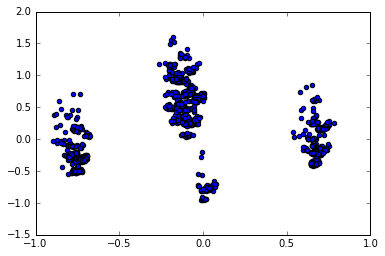

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(measurements)
measure_reduced = pca.transform(measurements)
import pylab as pl
pl.scatter(measure_reduced[:, 0], measure_reduced[:, 1])

Use PCA to reduce the dimentionality of the movies feature dataset and scatter the results. We can see three movie clusters generated. 

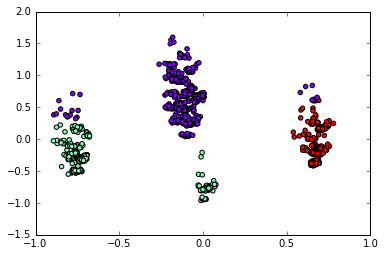

In [32]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3, random_state=0) # Fixing the RNG in kmeans
k_means.fit(measure_reduced)


pl.scatter(measure_reduced[:, 0], measure_reduced[:, 1], c=k_means.labels_,
           cmap='rainbow');

use k-means to cluster movies.

3


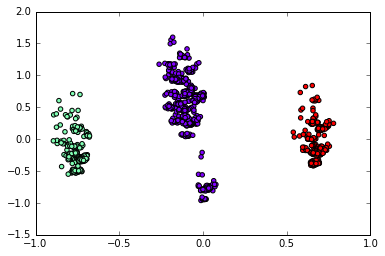

In [33]:
from sklearn.cluster import DBSCAN 
db_scan = DBSCAN(eps=0.5, min_samples=70)
db_scan.fit(measure_reduced)

print(len(set(db_scan.labels_)))
pl.scatter(measure_reduced[:, 0], measure_reduced[:, 1], c=db_scan.labels_,
           cmap='rainbow');


use DBSCAN to cluster movies. Looks better compared to above result.

Obtain three clusters dataframe and write these into csv files.

In [34]:
movie_data["label"] = db_scan.labels_

In [35]:
movie_data_0 = movie_data[movie_data.label==0]
movie_data_1 = movie_data[movie_data.label==1]
movie_data_2 = movie_data[movie_data.label==2]
movie_data_0.head()
movie_data_0.to_csv("movie_set_0.csv")
movie_data_1.to_csv("movie_set_1.csv")
movie_data_2.to_csv("movie_set_2.csv")

In [36]:
len(movie_data_0)+len(movie_data_1)+len(movie_data_2)

2033

Separate ratings into three files based on movies clusters

In [38]:
names = ['UserID', 'MovieID', 'Rating', 'Timestamp']
df = pd.read_csv("newRatings.csv", names=names, header=0)
df.head()

,UserID,MovieID,Rating,Timestamp
0,1,661,3,978302109
1,1,914,3,978301968
2,1,3408,4,978300275
3,1,1287,5,978302039
4,1,594,4,978302268


In [39]:
movie_df_0 = pd.read_csv("movie_set_0.csv")
movie_df_0 = movie_df_0.drop(movie_df_0.columns[0],axis=1)

movie_df_1 = pd.read_csv("movie_set_1.csv")
movie_df_1 = movie_df_1.drop(movie_df_1.columns[0],axis=1)

movie_df_2 = pd.read_csv("movie_set_2.csv")
movie_df_2 = movie_df_2.drop(movie_df_2.columns[0],axis=1)


In [40]:
first_cluster = movie_df_0["Movie ID"].tolist()
second_cluster = movie_df_1["Movie ID"].tolist()
third_cluster = movie_df_2["Movie ID"].tolist()

In [41]:
first_ratings_matrix = []
second_ratings_matrix = []
third_ratings_matrix = []
for row in df.itertuples():
    if row[2] in first_cluster:
        first_ratings_matrix.append([row[1],row[2],row[3],0])
    elif row[2] in second_cluster:
        second_ratings_matrix.append([row[1],row[2],row[3],1])  
    else:
        third_ratings_matrix.append([row[1],row[2],row[3],2]) 

Write ratings clusters into csv files.

In [42]:
import csv
with open('FirstRatingsMatrix.csv', 'a') as outcsv:   
    writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(['UserID','MovieID','Rating','label'])
    for item in first_ratings_matrix:
        writer.writerow([item[0], item[1], item[2], item[3]])  

In [43]:
with open('SecondRatingsMatrix.csv', 'a') as outcsv:   
    writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(['UserID','MovieID','Rating','label'])
    for item in second_ratings_matrix:
        writer.writerow([item[0], item[1], item[2], item[3]])

In [44]:
with open('ThirdRatingsMatrix.csv', 'a') as outcsv:   
    writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(['UserID','MovieID','Rating','label'])
    for item in third_ratings_matrix:
        writer.writerow([item[0], item[1], item[2], item[3]])

In [45]:
import math
import csv
from sklearn import metrics
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import linear_model, datasets

Logistic regression model for movie recommendation:
Reading in the clustered rating datasets and concatenating them to a data frame and then to a file (ratingsWlabels.csv)

In [46]:
df = pd.read_csv("FirstRatingsMatrix.csv")

In [47]:
df1 = pd.read_csv("SecondRatingsMatrix.csv")

In [48]:
df2 = pd.read_csv("ThirdRatingsMatrix.csv")

In [49]:
df = pd.concat([df, df1, df2])

In [50]:
df.shape

(579883, 4)

In [51]:
df.head()

,UserID,MovieID,Rating,label
0,1,661,3,0
1,1,914,3,0
2,1,594,4,0
3,1,938,4,0
4,1,2687,3,0


In [52]:
df.to_csv("ratingsWlabels")

In [53]:
f = open('userscsv', 'rt')
userList = []
try:
    reader = csv.reader(f)
    for row in reader:
        userList.append([row[0], row[1], row[2], row[3], row[4]])
                
finally:
    f.close()
print len(userList) 

12081


In [54]:
userList = userList[:6041]
userList[6040]

['6040', 'M', '25', '6', '11106']

In [55]:
f = open('ratingsWlabels', 'rt')
ratingsList = []
try:
    reader = csv.reader(f)
    for row in reader:
        ratingsList.append(row)
                
finally:
    f.close()
print len(ratingsList) 

579884


Including additional features for the users(age group and occupation) from the users.csv dataset to the ratingsWlabels dataset.

In [56]:
ratingsList1 = []
for row in ratingsList:
    for item in userList:
        if(row[1] == item[0]):
            ratingsList1.append([row[1], item[2], item[3], row[2], row[4], row[3]])
print len(ratingsList1) 

579883


In [57]:
ratingsList1[0]

['1', '1', '10', '661', '0', '3']

Converting the strings in the ratings list to numbers inorder to be compatible for logistic regression model

In [58]:
numList = []
for item in ratingsList1:
    item1 = list(map(int, item))
    numList.append(item1)
numList[0]    

[1, 1, 10, 661, 0, 3]

The first 5 values in each record are considered as features(uesr ID, user age group, user occupation, movie ID, movie cluster label) and the last value(rating) is considered as target.

In [59]:
X = []
y = []
for item in numList:
    X.append(item[:5])
    y.append(item[5])

Splitting into training and test data(80% for training and 20% for testing), and fitting the data into logistic regression model.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [61]:
logreg = linear_model.LogisticRegression(C=1e5)

In [62]:
logreg.fit(X_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [63]:
y_pred = logreg.predict(X_test)

We got about 1.4 Mean squared error using this logistic regression model for ratings prediction.

In [65]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_pred)

1.4339825999982756

Movie recommendation based on prediction using logistic regression:
For a coule of users, we looked at the movie details for the movies to which they gave a high rating (>3) in the training dataset and looked at the suggestions for them from out test data based on our prediction. For user ID# 1, the user seems to like Childeren's animation movies and comedies and we could see that our recommendation system came up with similar titles for that user. For user ID# 2, our recommendation system came up with a lot thrillers to align with the user's like of similar movies in the training dataset. 

In [73]:
training_data = []
for user,rating in zip(X_train,y_train):
    training_data.append([user[0],user[1],user[2],user[3],user[4],rating])

In [75]:
len(training_data)

463906

In [76]:
predicted_data = []
for user,rating in zip(X_test,y_pred):
    predicted_data.append([user[0],user[1],user[2],user[3],user[4],rating])

In [77]:
len(predicted_data)

115977

In [86]:
for user in training_data:
    if user[0] == 1:
        for movies in myList1:
            if str(user[3]) == movies[0]:
                print "Movie details: "
                print movies
                print "rating: "
                print user[5]

Movie details: 
['661', "Animation|Children's|Musical", 'James and the Giant Peach', '1996', 'Henry Selick', 'Simon Callow, Richard Dreyfuss', '6.7']
rating: 
3
Movie details: 
['1287', 'Action|Adventure|Drama', 'Ben-Hur', '1959', 'William Wyler', 'Charlton Heston, Jack Hawkins', '8.1']
rating: 
5
Movie details: 
['1566', "Adventure|Animation|Children's|Comedy|Musical", 'Hercules', '1997', 'Ron Clements,John Musker', 'Tate Donovan, Josh Keaton', '7.2']
rating: 
4
Movie details: 
['2028', 'Action|Drama|War', 'Saving Private Ryan', '1998', 'Steven Spielberg', 'Tom Hanks, Tom Sizemore', '8.6']
rating: 
5
Movie details: 
['588', "Animation|Children's|Comedy|Musical", 'Aladdin', '1992', 'Ron Clements,John Musker', 'Scott Weinger, Robin Williams', '8']
rating: 
4
Movie details: 
['1029', "Animation|Children's|Musical", 'Dumbo', '1941', 'Samuel Armstrong,Norman Ferguson', 'James Baskett, Herman Bing', '7.3']
rating: 
5
Movie details: 
['2687', "Animation|Children's", 'Tarzan', '1999', 'Chris 

In [87]:
for user in predicted_data:
    if user[0] == 1:
        for movies in myList1:
            if str(user[3]) == movies[0]:
                print "Movie details: "
                print movies
                print "rating: "
                print user[5]

Movie details: 
['1961', 'Drama', 'Rain Man', '1988', 'Barry Levinson', 'Dustin Hoffman, Tom Cruise', '8']
rating: 
4
Movie details: 
['1907', "Animation|Children's", 'Mulan', '1998', 'Tony Bancroft,Barry Cook', 'Ming-Na Wen, Lea Salonga', '7.5']
rating: 
4
Movie details: 
['1028', "Children's|Comedy|Musical", 'Mary Poppins', '1964', 'Robert Stevenson', 'Julie Andrews, Dick Van Dyke', '7.8']
rating: 
4
Movie details: 
['2321', 'Comedy', 'Pleasantville', '1998', 'Gary Ross', 'Tobey Maguire, Reese Witherspoon', '7.5']
rating: 
4
Movie details: 
['1270', 'Comedy|Sci-Fi', 'Back to the Future', '1985', 'Robert Zemeckis', 'Michael J. Fox, Christopher Lloyd', '8.5']
rating: 
4
Movie details: 
['1962', 'Drama', 'Driving Miss Daisy', '1989', 'Bruce Beresford', 'Morgan Freeman, Jessica Tandy', '7.4']
rating: 
4


In [88]:
for user in training_data:
    if user[0] == 2:
        for movies in myList1:
            if str(user[3]) == movies[0]:
                print "Movie details: "
                print movies
                print "rating: "
                print user[5]

Movie details: 
['1442', 'Drama', 'Prefontaine', '1997', 'Steve James', 'Jared Leto, R. Lee Ermey', '6.8']
rating: 
4
Movie details: 
['2881', 'Action|Thriller', 'Double Jeopardy', '1999', 'Bruce Beresford', 'Tommy Lee Jones, Ashley Judd', '6.4']
rating: 
3
Movie details: 
['3256', 'Action|Thriller', 'Patriot Games', '1992', 'Phillip Noyce', 'Harrison Ford, Anne Archer', '6.9']
rating: 
2
Movie details: 
['2858', 'Comedy|Drama', 'American Beauty', '1999', 'Sam Mendes', 'Kevin Spacey, Annette Bening', '8.4']
rating: 
4
Movie details: 
['2396', 'Comedy|Romance', 'Shakespeare in Love', '1998', 'John Madden', 'Geoffrey Rush, Tom Wilkinson', '7.2']
rating: 
4
Movie details: 
['1245', 'Drama', "Miller's Crossing", '1990', 'Joel Coen,Ethan Coen', 'Gabriel Byrne, Marcia Gay Harden', '7.9']
rating: 
2
Movie details: 
['1090', 'Drama|War', 'Platoon', '1986', 'Oliver Stone', 'Tom Berenger, Keith David', '8.1']
rating: 
2
Movie details: 
['2067', 'Drama|Romance|War', 'Doctor Zhivago', '1965', 'Dav

In [90]:
for user in predicted_data:
    if user[0] == 2:
        for movies in myList1:
            if str(user[3]) == movies[0]:
                print "Movie details: "
                print movies
                print "rating: "
                print user[5]

Movie details: 
['434', 'Action|Adventure|Crime', 'Cliffhanger', '1993', 'Renny Harlin', 'Sylvester Stallone, John Lithgow', '6.4']
rating: 
4
Movie details: 
['1537', 'Comedy', 'Shall We Dance?', '1996', 'Masayuki Suo', 'Kji Yakusho, Tamiyo Kusakari', '7.8']
rating: 
4
Movie details: 
['920', 'Drama|Romance|War', 'Gone with the Wind', '1939', 'Victor Fleming,George Cukor', "Thomas Mitchell, Barbara O'Neil", '8.2']
rating: 
4
Movie details: 
['982', 'Drama', 'Picnic', '1955', 'Joshua Logan', 'William Holden, Kim Novak', '7.2']
rating: 
4
Movie details: 
['380', 'Action|Adventure|Comedy|Romance', 'True Lies', '1994', 'James Cameron', 'Arnold Schwarzenegger, Jamie Lee Curtis', '7.2']
rating: 
4
Movie details: 
['2728', 'Drama', 'Spartacus', '1960', 'Stanley Kubrick', 'Kirk Douglas, Laurence Olivier', '7.9']
rating: 
4
Movie details: 
['1207', 'Drama', 'To Kill a Mockingbird', '1962', 'Robert Mulligan', 'Gregory Peck, John Megna', '8.4']
rating: 
4
Movie details: 
['1225', 'Drama', 'Amade

#####Section 3 - KNN - Comparative analysis with logistic regression. We applied knn on clusters formed with the movies dataset to predict the user ratings. Since the MSE obtained from Knn was significantly higher than Logistic regression, we used LR for predicting movie ratings. The code below shows our experiment with knn on 3 clusters formed using movies dataset and entire ratings dataset. we split the ratings dataset nased on movie clusters and applied knn. Something that stood out here was that mse was higher when we applied knn on individual clusters as compared to the entire ratings datset. 
1. Create a dataframe for each cluster and analyze the number of unique movie id’s and user id’s. This will help us in setting the dimensions for creating a similarity matrix.

In [7]:
import statsmodels.api as sm 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
import random
from numpy.random import permutation
import math
from sklearn import metrics
import numpy as np
df_first = pd.read_csv("/Users/sushma/Desktop/DM_Git/Recommender_System/FirstRatingsMatrix.csv", header=0)
df_first.head()

,UserID,MovieID,Rating,label
0,1,661,3,0
1,1,914,3,0
2,1,594,4,0
3,1,938,4,0
4,1,2687,3,0


#####Create a user is and movie id dictionary to map the actal id's into consecutive integers'

In [4]:
uniq_userid_clust1 = df_first.UserID.unique()
sorted_uniq_userid_clust1 = sorted(uniq_userid_clust1)
uindex_clust1 = 0
user_index_clust1 = {}
for n in sorted_uniq_userid_clust1:
    user_index_clust1[n] = uindex_clust1
    uindex_clust1 += 1
    
uniq_movieid_clust1 = df_first.MovieID.unique()
sorted_uniq_movieid_clust1 = sorted(uniq_movieid_clust1)
mindex_clust1 = 0
movie_index_clust1 = {}
for n in sorted_uniq_movieid_clust1:
    movie_index_clust1[n] = mindex_clust1
    mindex_clust1 += 1

In [5]:
n_users_clust1 = df_first.UserID.unique().shape[0]
print("n users: %s" % n_users_clust1)
n_movies_clust1 = df_first.MovieID.unique().shape[0]
print("n movies: %s" % n_movies_clust1)

n users: 6037
n movies: 727


#####Create a user-movie matrix using the number of unique user id’s as rows and number of unique movie id’s as columns.

In [8]:
first_clust_ratings = np.zeros((n_users_clust1,n_movies_clust1))
for row in df_first.itertuples():
    # row[1] will the user_id; row[2] the 
    # rating (see also my note below).
    # the -1 2s to move to 0 indexing.
    first_clust_ratings[user_index_clust1[row[1]]-1, movie_index_clust1[row[2]]-1] = row[3]
first_clust_ratings

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [9]:
sparsity = float(len(first_clust_ratings.nonzero()[0]))
sparsity /= (first_clust_ratings.shape[0] * first_clust_ratings.shape[1])
sparsity *= 100
print('sparsity: {:4.2f}%'.format(sparsity))

sparsity: 5.18%


#####Create a similarity matrix after splitting the data into testing and training sets. Here we used collaborative filtering approach and considered both user based and movie based predictions

In [10]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        if len(ratings[user, :].nonzero()[0]) > 5:
            # sample 6 ratings from each user to use
            # as 'test' data. If the users have less than 5 movies rated, do not include it for predictions
            test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                                size=6, 
                                                replace=False)
            # effectively remove these from the training
            # set
            train[user, test_ratings] = 0.
            test[user, test_ratings] = ratings[user, test_ratings]
           
    # make sure that test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    
    return train, test

In [11]:
train, test = train_test_split(first_clust_ratings)

In [12]:
def similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
        print(sim)
    elif kind == 'item':
        # we need only flip the dimensions around 
        # to do item based similarity!
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / (norms * norms.T))

In [13]:
user_similarity_clust1 = similarity(train, kind='user')
item_similarity_clust1 = similarity(train, kind='item')

[[  3.18000000e+02   5.60000000e+01   2.00000000e+01 ...,   2.00000000e+01
    4.10000000e+01   1.00000000e-09]
 [  5.60000000e+01   8.90000000e+01   2.50000000e+01 ...,   2.00000000e+01
    3.50000000e+01   1.00000000e-09]
 [  2.00000000e+01   2.50000000e+01   2.50000000e+01 ...,   1.00000000e-09
    1.50000000e+01   1.00000000e-09]
 ..., 
 [  2.00000000e+01   2.00000000e+01   1.00000000e-09 ...,   3.69000000e+02
    8.20000000e+01   1.60000000e+01]
 [  4.10000000e+01   3.50000000e+01   1.50000000e+01 ...,   8.20000000e+01
    6.56000000e+02   1.00000000e-09]
 [  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.60000000e+01
    1.00000000e-09   7.50000000e+01]]


In [14]:
sim = first_clust_ratings.dot(train.T) + 1e-9
sim

array([[  3.18000000e+02,   5.60000000e+01,   2.00000000e+01, ...,
          2.00000000e+01,   5.70000000e+01,   1.00000000e-09],
       [  9.30000000e+01,   8.90000000e+01,   2.50000000e+01, ...,
          2.00000000e+01,   6.60000000e+01,   1.00000000e-09],
       [  5.20000000e+01,   5.30000000e+01,   2.50000000e+01, ...,
          1.50000000e+01,   5.30000000e+01,   1.00000000e-09],
       ..., 
       [  3.60000000e+01,   2.00000000e+01,   1.00000000e-09, ...,
          3.69000000e+02,   1.02000000e+02,   2.80000000e+01],
       [  4.10000000e+01,   3.50000000e+01,   1.50000000e+01, ...,
          8.20000000e+01,   6.56000000e+02,   1.00000000e-09],
       [  1.00000000e-09,   1.00000000e-09,   1.00000000e-09, ...,
          1.60000000e+01,   1.60000000e+01,   7.50000000e+01]])

Compute the mean squared error for both user based and item based predictions
Consider only top k neighbors and re-compute the mean squared error and check if it improves the efficiency of the model.

In [15]:
def predict(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [16]:
from sklearn.metrics import mean_squared_error
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [17]:
item_prediction_clust1 = predict(train, item_similarity_clust1, kind='item')
user_prediction_clust1 = predict(train, user_similarity_clust1, kind='user')
print('User-based CF MSE: ' + str(get_mse(user_prediction_clust1, test)))
print('Movie-based CF MSE: ' + str(get_mse(item_prediction_clust1, test)))

User-based CF MSE: 9.51309268411
Movie-based CF MSE: 12.4780969769


In [18]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    
    for i in range(ratings.shape[0]):
        # note! the [::-1] craziness is just a numpy trick to 
        # reverse the array. we're doing this because otherwise
        # it is sorted in the direction opposite of what we want
        # -- lowest to highest, so least to most similar. 
        # we flip this around then take the top k.
        top_k_users =  np.argsort(similarity[:,i])[::-1][:k] #[np.argsort(similarity[:,i])[:-k-1:-1]]
        
        for j in range(ratings.shape[1]):
            pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
            pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))

    return pred

In [19]:
pred = predict_topk(train, user_similarity_clust1, k=40)
print('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

Top-k User-based CF MSE: 9.71655282666


#####Second cluster - knn - Repeat the steps for first cluster

In [20]:
df_second = pd.read_csv("/Users/sushma/Desktop/DM_Git/Recommender_System/SecondRatingsMatrix.csv", header=0)
df_second.head()

,UserID,MovieID,Rating,label
0,1,2918,4,1
1,1,2321,3,1
2,1,1270,5,1
3,1,1566,4,1
4,1,588,4,1


In [21]:
uniq_userid_clust2 = df_second.UserID.unique()
sorted_uniq_userid_clust2 = sorted(uniq_userid_clust2)
uindex_clust2 = 0
user_index_clust2 = {}
for n in sorted_uniq_userid_clust2:
    user_index_clust2[n] = uindex_clust2
    uindex_clust2 += 1
    
uniq_movieid_clust2 = df_second.MovieID.unique()
sorted_uniq_movieid_clust2 = sorted(uniq_movieid_clust2)
mindex_clust2 = 0
movie_index_clust2 = {}
for n in sorted_uniq_movieid_clust2:
    movie_index_clust2[n] = mindex_clust2
    mindex_clust2 += 1

In [22]:
n_users_clust2 = df_second.UserID.unique().shape[0]
print("n users: %s" % n_users_clust2)
n_movies_clust2 = df_second.MovieID.unique().shape[0]
print("n movies: %s" % n_movies_clust2)

n users: 5963
n movies: 558


In [23]:
second_clust_ratings = np.zeros((n_users_clust2,n_movies_clust2))
for row in df_second.itertuples():
    # row[1] will the user_id; row[2] the 
    # rating (see also my note below).
    # the -1 2s to move to 0 indexing.
    second_clust_ratings[user_index_clust2[row[1]]-1, movie_index_clust2[row[2]]-1] = row[3]
second_clust_ratings

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  3.],
       [ 0.,  0.,  0., ...,  0.,  0.,  5.]])

In [24]:
sparsity = float(len(second_clust_ratings.nonzero()[0]))
sparsity /= (second_clust_ratings.shape[0] * second_clust_ratings.shape[1])
sparsity *= 100
print('sparsity: {:4.2f}%'.format(sparsity))

sparsity: 5.60%


In [25]:
train, test = train_test_split(second_clust_ratings)

In [26]:
user_similarity_clust2 = similarity(train, kind='user')
item_similarity_clust2 = similarity(train, kind='item')

[[  8.50000000e+01   1.00000000e-09   5.00000000e+00 ...,   1.60000000e+01
    1.90000000e+01   1.00000000e-09]
 [  1.00000000e-09   1.26000000e+02   2.70000000e+01 ...,   2.00000000e+01
    6.50000000e+01   1.00000000e-09]
 [  5.00000000e+00   2.70000000e+01   2.99000000e+02 ...,   1.00000000e-09
    9.50000000e+01   1.00000000e-09]
 ..., 
 [  1.60000000e+01   2.00000000e+01   1.00000000e-09 ...,   3.50000000e+02
    8.10000000e+01   1.00000000e-09]
 [  1.90000000e+01   6.50000000e+01   9.50000000e+01 ...,   8.10000000e+01
    4.81000000e+02   1.00000000e-09]
 [  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.60000000e+01]]


In [27]:
sim = second_clust_ratings.dot(train.T) + 1e-9
sim

array([[  8.50000000e+01,   1.00000000e-09,   1.40000000e+01, ...,
          4.50000000e+01,   4.30000000e+01,   1.00000000e-09],
       [  1.00000000e-09,   1.26000000e+02,   2.70000000e+01, ...,
          4.60000000e+01,   8.30000000e+01,   1.00000000e-09],
       [  8.00000000e+00,   2.70000000e+01,   2.99000000e+02, ...,
          1.00000000e-09,   9.60000000e+01,   1.00000000e-09],
       ..., 
       [  1.60000000e+01,   2.00000000e+01,   1.00000000e-09, ...,
          3.50000000e+02,   1.15000000e+02,   1.00000000e-09],
       [  1.90000000e+01,   6.50000000e+01,   9.50000000e+01, ...,
          8.10000000e+01,   4.81000000e+02,   1.00000000e-09],
       [  9.00000000e+00,   1.50000000e+01,   1.00000000e-09, ...,
          3.60000000e+01,   1.50000000e+01,   1.60000000e+01]])

In [28]:
item_prediction_clust2 = predict(train, item_similarity_clust2, kind='item')
user_prediction_clust2 = predict(train, user_similarity_clust2, kind='user')
print('User-based CF MSE: ' + str(get_mse(user_prediction_clust2, test)))
print('Movie-based CF MSE: ' + str(get_mse(item_prediction_clust2, test)))

User-based CF MSE: 9.09233247274
Movie-based CF MSE: 12.0458075673


In [29]:
pred_clust2 = predict_topk(train, user_similarity_clust2, k=40)
print('Top-k User-based CF MSE: ' + str(get_mse(pred_clust2, test)))

Top-k User-based CF MSE: 9.56368844384


#####Third cluster - knn

In [30]:
df_third = pd.read_csv("/Users/sushma/Desktop/DM_Git/Recommender_System/ThirdRatingsMatrix.csv", header=0)
df_third.head()

,UserID,MovieID,Rating,label
0,1,3408,4,2
1,1,1287,5,2
2,1,527,5,2
3,1,1097,4,2
4,1,1545,4,2


In [31]:
uniq_userid_clust3 = df_third.UserID.unique()
sorted_uniq_userid_clust3 = sorted(uniq_userid_clust3)
uindex_clust3 = 0
user_index_clust3 = {}
for n in sorted_uniq_userid_clust3:
    user_index_clust3[n] = uindex_clust3
    uindex_clust3 += 1
    
uniq_movieid_clust3 = df_third.MovieID.unique()
sorted_uniq_movieid_clust3 = sorted(uniq_movieid_clust3)
mindex_clust3 = 0
movie_index_clust3 = {}
for n in sorted_uniq_movieid_clust3:
    movie_index_clust3[n] = mindex_clust3
    mindex_clust3 += 1

In [32]:
n_users_clust3 = df_third.UserID.unique().shape[0]
print("n users: %s" % n_users_clust3)
n_movies_clust3 = df_third.MovieID.unique().shape[0]
print("n movies: %s" % n_movies_clust3)

n users: 5981
n movies: 685


In [33]:
third_clust_ratings = np.zeros((n_users_clust3,n_movies_clust3))
for row in df_third.itertuples():
    # row[1] will the user_id; row[2] the 
    # rating (see also my note below).
    # the -1 2s to move to 0 indexing.
    third_clust_ratings[user_index_clust3[row[1]]-1, movie_index_clust3[row[2]]-1] = row[3]
third_clust_ratings

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  3.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [34]:
sparsity = float(len(third_clust_ratings.nonzero()[0]))
sparsity /= (third_clust_ratings.shape[0] * third_clust_ratings.shape[1])
sparsity *= 100
print('sparsity: {:4.2f}%'.format(sparsity))

sparsity: 4.06%


In [35]:
train, test = train_test_split(third_clust_ratings)

In [36]:
user_similarity_clust3 = similarity(train, kind='user')
item_similarity_clust3 = similarity(train, kind='item')

[[  5.02000000e+02   4.00000000e+01   5.50000000e+01 ...,   2.00000000e+01
    2.43000000e+02   1.00000000e-09]
 [  4.00000000e+01   6.40000000e+01   8.00000000e+00 ...,   1.00000000e-09
    4.40000000e+01   2.00000000e+01]
 [  5.50000000e+01   8.00000000e+00   7.00000000e+01 ...,   1.00000000e-09
    4.60000000e+01   1.60000000e+01]
 ..., 
 [  2.00000000e+01   1.00000000e-09   1.00000000e-09 ...,   6.40000000e+01
    4.00000000e+01   1.00000000e-09]
 [  2.43000000e+02   4.40000000e+01   4.60000000e+01 ...,   4.00000000e+01
    1.28200000e+03   3.60000000e+01]
 [  1.00000000e-09   2.00000000e+01   1.60000000e+01 ...,   1.00000000e-09
    3.60000000e+01   8.90000000e+01]]


In [37]:
sim = third_clust_ratings.dot(train.T) + 1e-9
sim

array([[  5.02000000e+02,   4.00000000e+01,   5.50000000e+01, ...,
          2.00000000e+01,   2.97000000e+02,   1.00000000e-09],
       [  4.00000000e+01,   6.40000000e+01,   8.00000000e+00, ...,
          1.00000000e-09,   4.40000000e+01,   2.00000000e+01],
       [  5.50000000e+01,   8.00000000e+00,   7.00000000e+01, ...,
          1.00000000e-09,   4.60000000e+01,   1.60000000e+01],
       ..., 
       [  4.00000000e+01,   1.00000000e-09,   1.60000000e+01, ...,
          6.40000000e+01,   7.60000000e+01,   1.60000000e+01],
       [  2.43000000e+02,   4.40000000e+01,   4.60000000e+01, ...,
          4.00000000e+01,   1.28200000e+03,   3.60000000e+01],
       [  5.60000000e+01,   2.00000000e+01,   4.10000000e+01, ...,
          1.00000000e-09,   1.10000000e+02,   8.90000000e+01]])

In [38]:
item_prediction_clust3 = predict(train, item_similarity_clust3, kind='item')
user_prediction_clust3 = predict(train, user_similarity_clust3, kind='user')
print('User-based CF MSE: ' + str(get_mse(user_prediction_clust3, test)))
print('Movie-based CF MSE: ' + str(get_mse(item_prediction_clust3, test)))

User-based CF MSE: 10.7402331801
Movie-based CF MSE: 14.0164353457


In [39]:
pred_clust3 = predict_topk(train, user_similarity_clust3, k=40)
print('Top-k User-based CF MSE: ' + str(get_mse(pred_clust3, test)))

Top-k User-based CF MSE: 11.6088414228


#####Entire Ratings dataset

In [43]:
names = ['UserID', 'MovieID', 'Rating', 'Timestamp']
df_entire = pd.read_csv("/Users/sushma/Desktop/DM_Git/Recommender_System/newRatings.csv", names=names, header=0)
df_entire.head()

,UserID,MovieID,Rating,Timestamp
0,1,661,3,978302109
1,1,914,3,978301968
2,1,3408,4,978300275
3,1,1287,5,978302039
4,1,594,4,978302268


In [44]:
uniq_userid = df_entire.UserID.unique()
sorted_uniq_userid = sorted(uniq_userid)
uindex = 0
user_index = {}
for n in sorted_uniq_userid:
    user_index[n] = uindex
    uindex += 1
    
uniq_movieid = df_entire.MovieID.unique()
sorted_uniq_movieid = sorted(uniq_movieid)
mindex = 0
movie_index = {}
for n in sorted_uniq_movieid:
    movie_index[n] = mindex
    mindex += 1

In [45]:
n_users = df_entire.UserID.unique().shape[0]
print("n users: %s" % n_users)
n_movies = df_entire.MovieID.unique().shape[0]
print("n movies: %s" % n_movies)

n users: 6040
n movies: 1970


In [46]:
entire_ratings = np.zeros((n_users,n_movies))
for row in df_entire.itertuples():
    # row[1] will the user_id; row[2] the 
    # rating (see also my note below).
    # the -1 2s to move to 0 indexing.
    entire_ratings[user_index[row[1]]-1, movie_index[row[2]]-1] = row[3]
entire_ratings

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  3.],
       [ 0.,  0.,  0., ...,  0.,  0.,  5.]])

In [48]:
sparsity = float(len(entire_ratings.nonzero()[0]))
sparsity /= (entire_ratings.shape[0] * entire_ratings.shape[1])
sparsity *= 100
print('sparsity: {:4.2f}%'.format(sparsity))

sparsity: 4.87%


In [52]:
train, test = train_test_split(entire_ratings)

In [53]:
user_similarity = similarity(train, kind='user')
item_similarity = similarity(train, kind='item')

[[  1.04500000e+03   1.29000000e+02   3.20000000e+01 ...,   9.20000000e+01
    4.17000000e+02   4.90000000e+01]
 [  1.29000000e+02   3.88000000e+02   5.30000000e+01 ...,   3.20000000e+01
    1.41000000e+02   1.50000000e+01]
 [  3.20000000e+01   5.30000000e+01   7.60000000e+01 ...,   1.00000000e-09
    4.10000000e+01   2.00000000e+01]
 ..., 
 [  9.20000000e+01   3.20000000e+01   1.00000000e-09 ...,   9.83000000e+02
    2.51000000e+02   9.30000000e+01]
 [  4.17000000e+02   1.41000000e+02   4.10000000e+01 ...,   2.51000000e+02
    2.57600000e+03   1.24000000e+02]
 [  4.90000000e+01   1.50000000e+01   2.00000000e+01 ...,   9.30000000e+01
    1.24000000e+02   3.94000000e+02]]


In [54]:
sim = entire_ratings.dot(train.T) + 1e-9
sim

array([[ 1045.,   149.,    52., ...,    92.,   417.,    49.],
       [  135.,   388.,    53., ...,    40.,   193.,    15.],
       [   87.,    61.,    76., ...,    16.,    99.,    61.],
       ..., 
       [  121.,    52.,    15., ...,   983.,   273.,    93.],
       [  417.,   141.,    41., ...,   291.,  2576.,   124.],
       [   85.,    35.,    20., ...,   109.,   156.,   394.]])

In [55]:
item_prediction = predict(train, item_similarity, kind='item')
user_prediction = predict(train, user_similarity, kind='user')
print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print('Movie-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 9.40545355092
Movie-based CF MSE: 12.8494402941


In [56]:
pred_entire = predict_topk(train, user_similarity, k=40)
print('Top-k User-based CF MSE: ' + str(get_mse(pred_entire, test)))

Top-k User-based CF MSE: 7.9143489793
